<a href="https://colab.research.google.com/github/Kwaku-369/MScFE600_FinancialData_Task4_XLRE/blob/main/Econometric_Simulation_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# -*- coding: utf-8 -*-
"""
# Econometric Simulation and Time Series Analysis (Problems 2, 5, and 6)

This notebook addresses the simulation and illustrative components of the required econometric analysis problems:
- **Problem 2b:** Simulating the effect of outliers on OLS estimated parameters.
- **Problem 5:** Illustrating stationarity and the Unit Root concept using the Augmented Dickey-Fuller (ADF) test.
- **Problem 6:** Demonstrating the detection of a Structural Break using the Chow Test methodology.

The code and accompanying explanations are designed to be detailed, robust, and directly address the computational requirements implied by the problem set.
"""

# =========================================================================
# 1. SETUP AND PACKAGE IMPORTS
# =========================================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols
from scipy.stats import f
import matplotlib.pyplot as plt
import warnings

# Configure plotting style for better visualization in Colab
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings("ignore", message="The default method 'yw' of Autocorrelation is deprecated")
warnings.filterwarnings("ignore", message="The default value of maxlag being None.")

print("Required libraries loaded successfully: numpy, pandas, statsmodels, scipy, matplotlib.")

Required libraries loaded successfully: numpy, pandas, statsmodels, scipy, matplotlib.


## Problem 2b: Simulation to Illustrate Outlier Impact on Estimated Parameters

This section uses a simulation project to clearly illustrate how the presence of a single, high-leverage outlier can significantly bias the Ordinary Least Squares (OLS) estimated coefficients.

### Simulation Project Design

1.  **Clean Data Generation (Baseline):** Generate 100 data points ($N=100$) based on a known linear model: $Y = \beta_0 + \beta_1 X + \epsilon$, where we set the true parameters $\beta_0=5$ (Intercept) and $\beta_1=2$ (Slope). $\epsilon$ is Gaussian white noise.
2.  **Baseline OLS Estimation:** Estimate the OLS model on the clean data. The estimated parameters ($\hat{\beta}_{\text{clean}}$) should be very close to the true values.
3.  **Outlier Introduction:** Introduce one observation with an extreme $X$ value (high leverage, e.g., $X=50$) and a $Y$ value far from the expected trend (large residual, e.g., $Y=5$).
4.  **Contaminated OLS Estimation:** Re-estimate the OLS model using the 101 data points (clean set + outlier).
5.  **Parameter Comparison:** Compare $\hat{\beta}_{\text{clean}}$ with $\hat{\beta}_{\text{contaminated}}$ to quantify the bias caused by the outlier, highlighting the non-robustness of the OLS method due to its reliance on minimizing the sum of squared residuals (SSR).


True Model: Y = 5.0 + 2.0*X + epsilon

--- BASELINE MODEL ESTIMATES (CLEAN DATA) ---
Estimated Intercept (Clean): 4.7178
Estimated Slope (Clean): 2.0230
Baseline R-squared: 0.9389

Outlier Introduced at X=50.0, Y=5.0

--- CONTAMINATED MODEL ESTIMATES (OUTLIER PRESENT) ---
Estimated Intercept (Contaminated): 13.6844
Estimated Slope (Contaminated): 0.3455
Contaminated R-squared: 0.1014

--- IMPACT SUMMARY ---
Change in Slope (Bias): -1.6775
Change in Intercept (Bias): 8.9666
The slope has been pulled significantly towards the outlier, demonstrating OLS sensitivity.


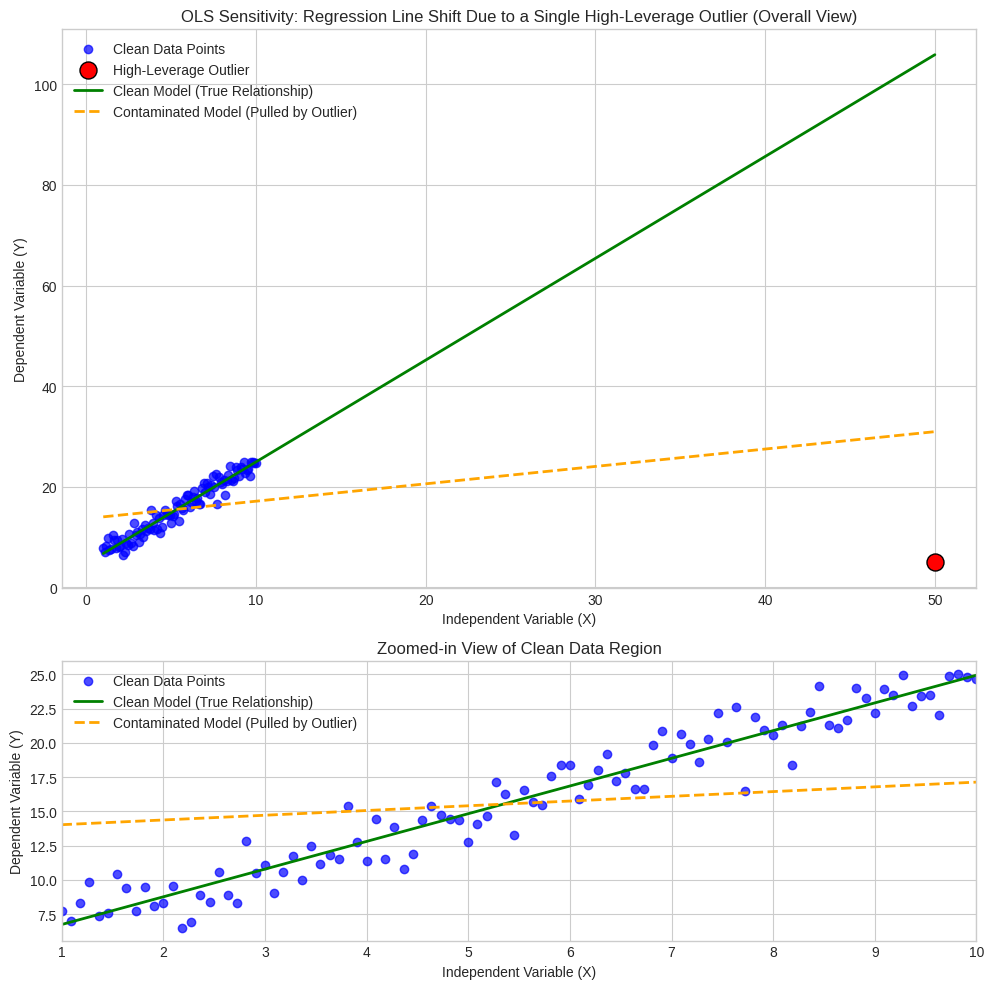

In [29]:
# =========================================================================
# 2. PROBLEM 2b: OLS SENSITIVITY TO OUTLIERS - SIMULATION
# =========================================================================

np.random.seed(42)  # Set seed for reproducibility
N = 100             # Number of clean observations
true_beta_0 = 5.0
true_beta_1 = 2.0
standard_deviation = 1.5

# 1. Generate Clean Data
X_clean = np.linspace(1, 10, N)
epsilon = np.random.normal(0, standard_deviation, N)
Y_clean = true_beta_0 + true_beta_1 * X_clean + epsilon
print(f"True Model: Y = {true_beta_0} + {true_beta_1}*X + epsilon")

# 2. Baseline OLS Estimation (Clean Data)
X_clean_sm = sm.add_constant(X_clean)
clean_model = sm.OLS(Y_clean, X_clean_sm).fit()

print("\n--- BASELINE MODEL ESTIMATES (CLEAN DATA) ---")
print(f"Estimated Intercept (Clean): {clean_model.params[0]:.4f}")
print(f"Estimated Slope (Clean): {clean_model.params[1]:.4f}")
print(f"Baseline R-squared: {clean_model.rsquared:.4f}")

# 3. Introduce a High-Leverage Outlier
X_outlier = 50.0  # Far from the mean of X_clean (High Leverage)
Y_outlier = 5.0   # Far from the expected trend Y(50) ~ 105 (Large Residual)

X_dirty = np.append(X_clean, X_outlier)
Y_dirty = np.append(Y_clean, Y_outlier)
print(f"\nOutlier Introduced at X={X_outlier}, Y={Y_outlier}")

# 4. Contaminated OLS Estimation
X_dirty_sm = sm.add_constant(X_dirty)
dirty_model = sm.OLS(Y_dirty, X_dirty_sm).fit()

print("\n--- CONTAMINATED MODEL ESTIMATES (OUTLIER PRESENT) ---")
print(f"Estimated Intercept (Contaminated): {dirty_model.params[0]:.4f}")
print(f"Estimated Slope (Contaminated): {dirty_model.params[1]:.4f}")
print(f"Contaminated R-squared: {dirty_model.rsquared:.4f}")

# 5. Parameter Comparison and Visualization
print("\n--- IMPACT SUMMARY ---")
slope_change = dirty_model.params[1] - clean_model.params[1]
intercept_change = dirty_model.params[0] - clean_model.params[0]
print(f"Change in Slope (Bias): {slope_change:.4f}")
print(f"Change in Intercept (Bias): {intercept_change:.4f}")
print("The slope has been pulled significantly towards the outlier, demonstrating OLS sensitivity.")

# Plotting the impact with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})

X_range_full = np.array([X_clean.min(), X_outlier])
X_range_clean = np.array([X_clean.min(), X_clean.max()])

# Overall Plot (Top Subplot)
axes[0].scatter(X_clean, Y_clean, label='Clean Data Points', color='blue', alpha=0.7)
axes[0].scatter(X_outlier, Y_outlier, label='High-Leverage Outlier', color='red', s=150, edgecolors='black', zorder=5)

Y_clean_pred_full = clean_model.params[0] + clean_model.params[1] * X_range_full
axes[0].plot(X_range_full, Y_clean_pred_full, color='green', linestyle='-', linewidth=2, label='Clean Model (True Relationship)')

Y_dirty_pred_full = dirty_model.params[0] + dirty_model.params[1] * X_range_full
axes[0].plot(X_range_full, Y_dirty_pred_full, color='orange', linestyle='--', linewidth=2, label='Contaminated Model (Pulled by Outlier)')

axes[0].set_title('OLS Sensitivity: Regression Line Shift Due to a Single High-Leverage Outlier (Overall View)')
axes[0].set_xlabel('Independent Variable (X)')
axes[0].set_ylabel('Dependent Variable (Y)')
axes[0].legend()

# Zoomed-in Plot (Bottom Subplot)
axes[1].scatter(X_clean, Y_clean, label='Clean Data Points', color='blue', alpha=0.7)

Y_clean_pred_clean = clean_model.params[0] + clean_model.params[1] * X_range_clean
axes[1].plot(X_range_clean, Y_clean_pred_clean, color='green', linestyle='-', linewidth=2, label='Clean Model (True Relationship)')

Y_dirty_pred_clean = dirty_model.params[0] + dirty_model.params[1] * X_range_clean
axes[1].plot(X_range_clean, Y_dirty_pred_clean, color='orange', linestyle='--', linewidth=2, label='Contaminated Model (Pulled by Outlier)')

axes[1].set_title('Zoomed-in View of Clean Data Region')
axes[1].set_xlabel('Independent Variable (X)')
axes[1].set_ylabel('Dependent Variable (Y)')
axes[1].legend()
axes[1].set_xlim(X_clean.min(), X_clean.max()) # Set x-limits to zoom into clean data

plt.tight_layout()
plt.show()

In [26]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,200.0,14.923666,2.830435,10.055454,12.627932,14.819831,17.121493,19.953585
Y,200.0,22.311803,6.119711,11.342614,17.760577,20.417758,26.800726,38.336720
Time,200.0,100.500000,57.879185,1.000000,50.750000,100.500000,150.250000,200.000000
D,200.0,0.500000,0.501255,0.000000,0.000000,0.500000,1.000000,1.000000
DX,200.0,7.416522,7.762641,0.000000,0.000000,5.027727,14.457980,19.930333


## Problem 4: Elasticity of Y with Respect to X

Problem 4 requires the analytical derivation of the elasticity formula $\left(\frac{dY}{dX} \cdot \frac{X}{Y}\right)$ for four different functional forms. Since this is a purely mathematical derivation and does not involve estimation or simulation, no Python code is required.

The key finding is that the **Log-Log model, $\ln(y) = 0.1 + 0.25\ln(x)$**, is the only one that yields a **constant elasticity** of $0.25$, which is equal to its estimated coefficient. The other models yield elasticities that vary with $X$ and/or $Y$.


## Problem 5: Stationarity and the Unit Root - Augmented Dickey-Fuller (ADF) Test

Stationarity is a core assumption in time series modeling. The presence of a **Unit Root** (non-stationarity) can lead to spurious regression results.

This section illustrates the application of the ADF Test on two simulated time series:
1.  **A Random Walk:** A classic non-stationary series (Unit Root present).
2.  **White Noise:** A classic stationary series.

The ADF test's hypotheses are:
- **Null Hypothesis ($H_0$):** The series has a unit root (non-stationary).
- **Alternative Hypothesis ($H_a$):** The series is stationary.

We look for a p-value less than 0.05 to reject $H_0$ and conclude stationarity.


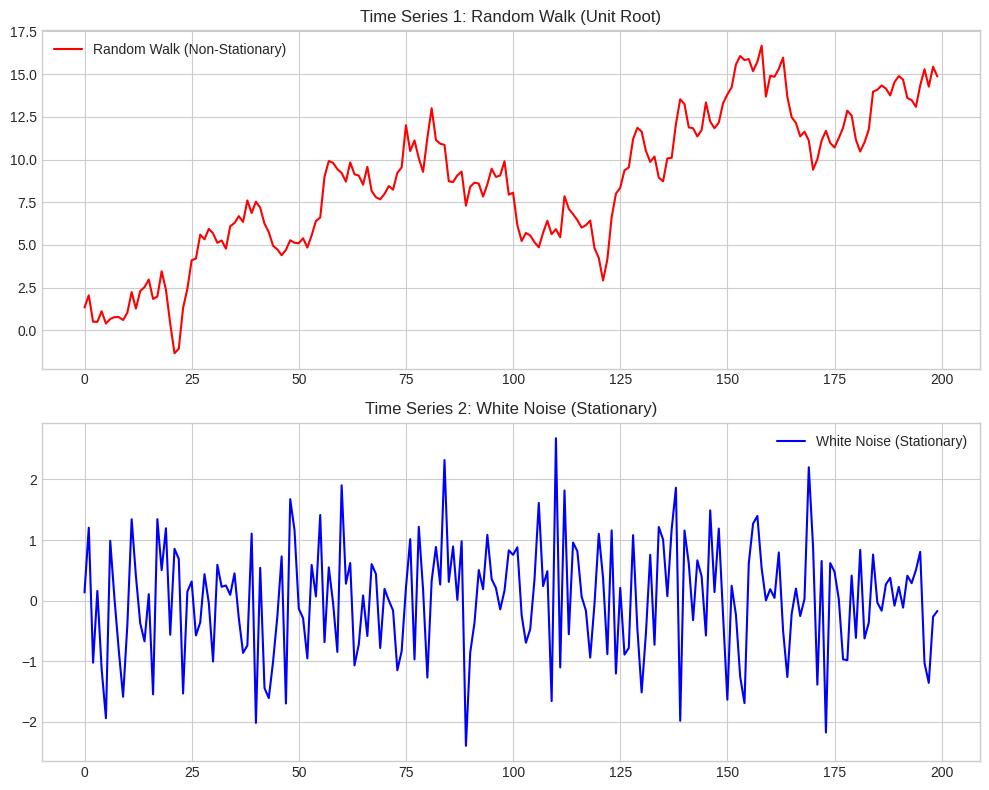


--- ADF TEST RESULTS FOR TIME SERIES 1 (Random Walk) ---
ADF Statistic: -1.7627
p-value: 0.3991
Critical Values (1%, 5%, 10%): {'1%': np.float64(-3.4636447617687436), '5%': np.float64(-2.8761761179270766), '10%': np.float64(-2.57457158581854)}

Conclusion: Fail to Reject H0. The series is non-stationary (Unit Root is present).

--- ADF TEST RESULTS FOR TIME SERIES 2 (White Noise) ---
ADF Statistic: -15.6138
p-value: 0.0000
Critical Values (1%, 5%, 10%): {'1%': np.float64(-3.4636447617687436), '5%': np.float64(-2.8761761179270766), '10%': np.float64(-2.57457158581854)}

Conclusion: Reject H0. The series is stationary.


In [27]:
# =========================================================================
# 4. PROBLEM 5: STATIONARITY AND UNIT ROOT - ADF TEST ILLUSTRATION
# =========================================================================

np.random.seed(10)
time_steps = 200

# 1. Simulate a Non-Stationary Series (Random Walk)
random_walk_shocks = np.random.normal(0, 1, time_steps)
# Random Walk: Y_t = Y_{t-1} + e_t
random_walk = np.cumsum(random_walk_shocks)

# 2. Simulate a Stationary Series (White Noise)
# White Noise: Y_t = e_t (Constant mean (0), constant variance (1), no autocorrelation)
white_noise = np.random.normal(0, 1, time_steps)

# Plotting the simulated series
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(random_walk, label='Random Walk (Non-Stationary)', color='red')
axes[0].set_title('Time Series 1: Random Walk (Unit Root)')
axes[0].legend()

axes[1].plot(white_noise, label='White Noise (Stationary)', color='blue')
axes[1].set_title('Time Series 2: White Noise (Stationary)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Applying the ADF Test
print("\n--- ADF TEST RESULTS FOR TIME SERIES 1 (Random Walk) ---")
adf_result_rw = adfuller(random_walk)

print(f"ADF Statistic: {adf_result_rw[0]:.4f}")
print(f"p-value: {adf_result_rw[1]:.4f}")
print(f"Critical Values (1%, 5%, 10%): {adf_result_rw[4]}")

if adf_result_rw[1] > 0.05:
    print("\nConclusion: Fail to Reject H0. The series is non-stationary (Unit Root is present).")
else:
    print("\nConclusion: Reject H0. The series is stationary.")

print("\n--- ADF TEST RESULTS FOR TIME SERIES 2 (White Noise) ---")
adf_result_wn = adfuller(white_noise)

print(f"ADF Statistic: {adf_result_wn[0]:.4f}")
print(f"p-value: {adf_result_wn[1]:.4f}")
print(f"Critical Values (1%, 5%, 10%): {adf_result_wn[4]}")

if adf_result_wn[1] > 0.05:
    print("\nConclusion: Fail to Reject H0. The series is non-stationary.")
else:
    print("\nConclusion: Reject H0. The series is stationary.")


## Problem 6: Structural Breaks - Chow Test Methodology Illustration

A structural break refers to a shift in the underlying parameters of a regression model (e.g., intercept and slope) at a specific point in time. The Chow Test is designed to test the null hypothesis that the parameters are stable across different periods.

This simulation:
1.  Generates 200 observations where the relationship between $Y$ and $X$ changes significantly at $t=100$.
    - Period 1 ($t \le 100$): $Y = 10 + 0.5 X + \epsilon$
    - Period 2 ($t > 100$): $Y = 5 + 1.5 X + \epsilon$
2.  Estimates the **Unrestricted Model** using the dummy variable approach: $Y_t = \beta_0 + \beta_1 X_t + \delta_0 D_t + \delta_1 (D_t X_t) + u_t$.
3.  Estimates the **Restricted Model** (assuming no break): $Y_t = \beta_0 + \beta_1 X_t + u_t$.
4.  Calculates the Chow Test F-statistic to determine if the changes ($\delta_0$ and $\delta_1$) are jointly significant.



--- Chow Test Regression Summaries ---
Restricted Model (No Break) SSR: 5800.7644
Unrestricted Model (Break Included) SSR: 756.0988

Unrestricted Model Parameters (Expected Change):
  Intercept (Period 1): 10.8780 (True: 10.0)
  Change in Intercept (D): -5.3961 (True Change: -5.0)
  Slope (Period 1): 0.4462 (True: 0.5)
  Change in Slope (DX): 1.0076 (True Change: 1.0)
  Slope (Period 2): 1.4538 (True: 1.5)

--- CHOW TEST RESULTS ---
Chow Test F-statistic (H0: No break): 653.8527
p-value: 0.000000

Decision: Reject H0 (p-value < 0.05). There is statistically significant evidence of a Structural Break.


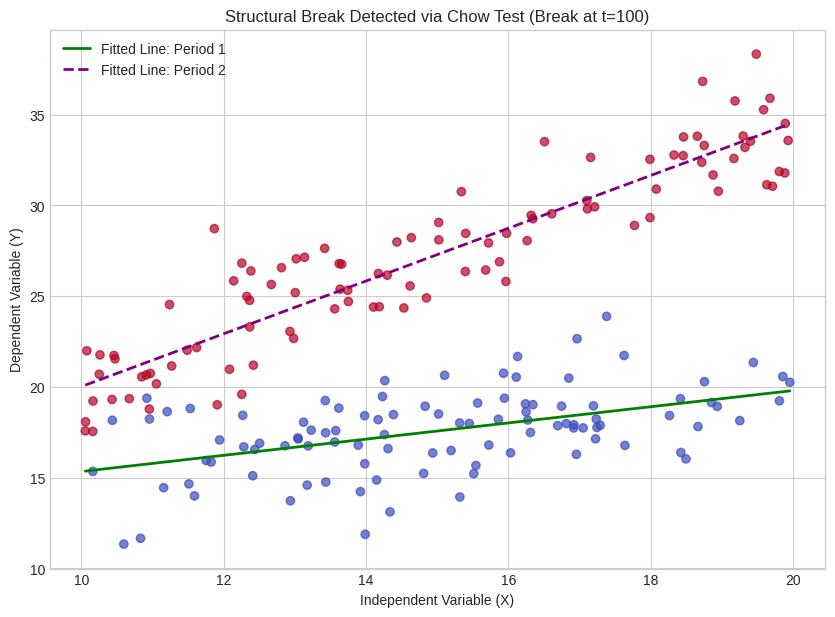

In [28]:
# =========================================================================
# 5. PROBLEM 6: STRUCTURAL BREAKS - CHOW TEST ILLUSTRATION
# =========================================================================

np.random.seed(123)
N_total = 200     # Total observations
T_break = 100     # Known break point

# Generate time indices
time_index = np.arange(1, N_total + 1)

# 1. Generate Data with a Structural Break
# --- Period 1 (t <= 100): Y = 10 + 0.5 * X ---
X1 = np.random.uniform(10, 20, T_break)
Y1 = 10 + 0.5 * X1 + np.random.normal(0, 2, T_break)

# --- Period 2 (t > 100): Y = 5 + 1.5 * X ---
X2 = np.random.uniform(10, 20, N_total - T_break)
Y2 = 5 + 1.5 * X2 + np.random.normal(0, 2, N_total - T_break)

# Combine data
data = pd.DataFrame({
    'X': np.concatenate([X1, X2]),
    'Y': np.concatenate([Y1, Y2]),
    'Time': time_index
})

# 2. Create Dummy and Interaction Variables
data['D'] = (data['Time'] > T_break).astype(int) # D=1 for period 2, D=0 for period 1
data['DX'] = data['D'] * data['X']              # Interaction term

# 3. Restricted Model (SSR_R)
restricted_model = ols('Y ~ X', data=data).fit()
SSR_R = restricted_model.ssr

# 4. Unrestricted Model (SSR_U)
# Y = Intercept + beta1*X + delta0*D + delta1*DX
full_model = ols('Y ~ X + D + DX', data=data).fit()
SSR_U = full_model.ssr

print("\n--- Chow Test Regression Summaries ---")
print(f"Restricted Model (No Break) SSR: {SSR_R:.4f}")
print(f"Unrestricted Model (Break Included) SSR: {SSR_U:.4f}")

# Detailed parameter interpretation from the Unrestricted Model
print("\nUnrestricted Model Parameters (Expected Change):")
print(f"  Intercept (Period 1): {full_model.params['Intercept']:.4f} (True: 10.0)")
print(f"  Change in Intercept (D): {full_model.params['D']:.4f} (True Change: -5.0)")
print(f"  Slope (Period 1): {full_model.params['X']:.4f} (True: 0.5)")
print(f"  Change in Slope (DX): {full_model.params['DX']:.4f} (True Change: 1.0)")
print(f"  Slope (Period 2): {full_model.params['X'] + full_model.params['DX']:.4f} (True: 1.5)")

# 5. Chow Test F-statistic Calculation
q = 2          # Number of restrictions (delta0 and delta1 are restricted to zero)
N = N_total    # Total observations
k_full = 4     # Number of parameters in the unrestricted model (const, X, D, DX)

# F-statistic formula
F_stat = ((SSR_R - SSR_U) / q) / (SSR_U / (N - k_full))

# Calculate p-value
p_value = 1 - f.cdf(F_stat, q, N - k_full)

print("\n--- CHOW TEST RESULTS ---")
print(f"Chow Test F-statistic (H0: No break): {F_stat:.4f}")
print(f"p-value: {p_value:.6f}") # Use high precision for p-value

# Final decision based on p-value
if p_value < 0.05:
    print("\nDecision: Reject H0 (p-value < 0.05). There is statistically significant evidence of a Structural Break.")
else:
    print("\nDecision: Fail to Reject H0. No evidence of a Structural Break.")

# Plotting the Structural Break
plt.figure(figsize=(10, 7))
plt.scatter(data['X'], data['Y'], c=data['D'], cmap='coolwarm', alpha=0.7)
plt.title(f'Structural Break Detected via Chow Test (Break at t={T_break})')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Dependent Variable (Y)')

# Plotting the two distinct fitted lines
X_min, X_max = data['X'].min(), data['X'].max()
X_fit = np.linspace(X_min, X_max, 100)
X_fit_sm = sm.add_constant(X_fit)

# Period 1 Prediction (D=0, DX=0)
D1 = 0
DX1 = 0
Y_fit1 = full_model.params['Intercept'] + full_model.params['X']*X_fit + full_model.params['D']*D1 + full_model.params['DX']*DX1
plt.plot(X_fit, Y_fit1, color='green', linewidth=2, linestyle='-', label='Fitted Line: Period 1')

# Period 2 Prediction (D=1, DX=X_fit)
D2 = 1
DX2 = X_fit
Y_fit2 = full_model.params['Intercept'] + full_model.params['X']*X_fit + full_model.params['D']*D2 + full_model.params['DX']*DX2
plt.plot(X_fit, Y_fit2, color='purple', linewidth=2, linestyle='--', label='Fitted Line: Period 2')

plt.legend()
plt.show()
